In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.sparse.linalg import svds
from numpy.linalg import norm
from sklearn.decomposition import IncrementalPCA
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
from collections import OrderedDict
import math
import time

In [7]:
# !pip install ucimlrepo

In [8]:
# from ucimlrepo import fetch_ucirepo

# online_retail = fetch_ucirepo(id=352)

# X = online_retail.data.features
# y = online_retail.data.targets

# print(online_retail.metadata)

# print(online_retail.variables)


In [9]:
# df = pd.concat([online_retail.data.features, online_retail.data.targets], axis=1)
# print("Initial shape:", df.shape)
# print(df.info())

# # Bring index columns (InvoiceNo, StockCode) into DataFrame
# df = df.reset_index()  # converts multi-index columns to regular ones
# print("Columns after reset:", df.columns.tolist())
# print("Shape after reset:", df.shape)

In [11]:
url = "https://archive.ics.uci.edu/static/public/352/data.csv"
df = pd.read_csv(url, encoding='ISO-8859-1')

print("Initial shape:", df.shape)
print(df.columns)

Initial shape: (541909, 8)
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [ ]:
df = df.dropna(subset=["CustomerID", "Description"])

df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df = df[~df["InvoiceNo"].astype(str).str.startswith('C')]

df = df.drop_duplicates()

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df = df.reset_index(drop=True)

print("Cleaned dataset shape:", df.shape)
print(df.head())


Cleaned dataset shape: (392692, 9)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  


## Part 2

In [ ]:
df_basket = df[['InvoiceNo', 'Description', 'Quantity']]
basket_grouped = df_basket.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
# basket_grouped.head(5)

basket_binary = basket_grouped.map(lambda x: 1 if x > 0 else 0)
print("item-transaction matrix shape:", basket_binary.shape)
print("Non-zero entries:", int(basket_binary.values.sum()))
basket_binary.head()


item-transaction matrix shape: (18532, 3877)
Non-zero entries: 387738


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sample_invoice = basket_binary.sample(1)
print("Invoice number:", sample_invoice.index[0])

items_bought = sample_invoice.loc[sample_invoice.index[0]]
items_bought = items_bought[items_bought == 1]
print("Number of items bought:", len(items_bought))
print(items_bought.index.tolist())

Invoice number: 553846
Number of items bought: 9
['12 PENCILS SMALL TUBE SKULL', 'BLUE PARTY BAGS ', 'CHILDRENS CUTLERY RETROSPOT RED ', 'PAPER BUNTING RETROSPOT', 'PINK HAPPY BIRTHDAY BUNTING', 'RED RETROSPOT BIG BOWL', 'SET OF 20 KIDS COOKIE CUTTERS', 'SET/6 RED SPOTTY PAPER CUPS', 'SET/6 RED SPOTTY PAPER PLATES']


## Part 3

In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.sort_values('InvoiceDate')
df['Batch'] = df['InvoiceDate'].dt.to_period('W').astype(str)
print(df['Batch'].value_counts().sort_index())

batches = df['Batch'].unique()
data_stream = {batch: df[df['Batch'] == batch] for batch in batches}
print(f"Total batches created: {len(data_stream)}")

Batch
2010-11-29/2010-12-05     7545
2010-12-06/2010-12-12     9377
2010-12-13/2010-12-19     6975
2010-12-20/2010-12-26     1773
2011-01-03/2011-01-09     5190
2011-01-10/2011-01-16     4641
2011-01-17/2011-01-23     4624
2011-01-24/2011-01-30     5537
2011-01-31/2011-02-06     5030
2011-02-07/2011-02-13     3772
2011-02-14/2011-02-20     5198
2011-02-21/2011-02-27     5740
2011-02-28/2011-03-06     5542
2011-03-07/2011-03-13     5348
2011-03-14/2011-03-20     5958
2011-03-21/2011-03-27     6377
2011-03-28/2011-04-03     6414
2011-04-04/2011-04-10     6139
2011-04-11/2011-04-17     6398
2011-04-18/2011-04-24     4855
2011-04-25/2011-05-01     3680
2011-05-02/2011-05-08     6061
2011-05-09/2011-05-15     7395
2011-05-16/2011-05-22     7606
2011-05-23/2011-05-29     5671
2011-05-30/2011-06-05     4771
2011-06-06/2011-06-12     7048
2011-06-13/2011-06-19     6652
2011-06-20/2011-06-26     6056
2011-06-27/2011-07-03     4688
2011-07-04/2011-07-10     5770
2011-07-11/2011-07-17     6256
20

In [16]:
for b in list(data_stream.keys())[:2]:
    print(f"\n Batch {b}:")
    print(data_stream[b].head(3)[['InvoiceNo', 'InvoiceDate', 'Description', 'Quantity']])


 Batch 2010-11-29/2010-12-05:
  InvoiceNo         InvoiceDate                         Description  Quantity
0    536365 2010-12-01 08:26:00  WHITE HANGING HEART T-LIGHT HOLDER         6
1    536365 2010-12-01 08:26:00                 WHITE METAL LANTERN         6
2    536365 2010-12-01 08:26:00      CREAM CUPID HEARTS COAT HANGER         8

 Batch 2010-12-06/2010-12-12:
     InvoiceNo         InvoiceDate                  Description  Quantity
7553    537226 2010-12-06 08:34:00  PAPERWEIGHT SAVE THE PLANET         6
7551    537226 2010-12-06 08:34:00     GOLD EAR MUFF HEADPHONES         2
7552    537226 2010-12-06 08:34:00      IVORY KNITTED MUG COSY          6


In [17]:
batches_ordered = [(b, data_stream[b]) for b in sorted(data_stream.keys())]


## Part 4

In [18]:
#@title Frequent Directions (FD)

class FrequentDirections:
    def __init__(self, ell, d):
        self.ell = ell
        self.d = d
        self.B = np.zeros((ell, d), dtype=np.float64)
        self.n_rows = 0

    def _shrink(self):
        U, s, Vt = np.linalg.svd(self.B, full_matrices=False)
        if len(s) < self.ell:
            s = np.pad(s, (0, self.ell - len(s)))
        delta = s[self.ell-1]**2
        s_sq = np.maximum(s**2 - delta, 0.0)
        s_shrunk = np.sqrt(s_sq)
        self.B = np.diag(s_shrunk) @ Vt
        self.B[np.abs(self.B) < 1e-12] = 0.0

    def process_row(self, x):
        self.n_rows += 1
        zero_row_idx = None
        for i in range(self.ell):
            if not self.B[i].any():
                zero_row_idx = i
                break
        if zero_row_idx is None:
            self.B[-1, :] = x.toarray().ravel() if sparse.issparse(x) else x
            self._shrink()
        else:
            self.B[zero_row_idx, :] = x.toarray().ravel() if sparse.issparse(x) else x

    def process_block(self, X):
        if sparse.issparse(X):
            for i in range(X.shape[0]):
                self.process_row(X[i])
        else:
            for i in range(X.shape[0]):
                self.process_row(X[i, :])

    def get_sketch(self):
        return self.B.copy()

In [ ]:
#@title Random Gaussian Projection
class RandomGaussianSketch:
    def __init__(self, d, k, seed=0):
        rng = np.random.RandomState(seed)
        # R is d x k
        self.R = rng.normal(0, 1.0/np.sqrt(k), size=(d, k))
        self.k = k
        self.S = None 

    def update(self, X):
        XR = (X @ self.R) if sparse.issparse(X) else X.dot(self.R)
        if self.S is None:
            self.S = XR
        else:
            self.S = np.vstack([self.S, XR])

    def get_sketch_matrix(self):
        return self.S

In [ ]:
def build_item_transaction_matrix(batch_df):
    
    g = batch_df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack(fill_value=0)
    
    g = (g > 0).astype(np.int8)
    X = sparse.csr_matrix(g.values)
    invoices = g.index.tolist()
    items = g.columns.tolist()
    return X, invoices, items

def build_batch_matrix_with_global_vocab(batch_df, item_to_idx, n_items):
    
    invoices = batch_df['InvoiceNo'].astype(str).unique()
    invoice_to_row = {inv: i for i, inv in enumerate(invoices)}

    rows, cols, data = [], [], []
    for _, r in batch_df.iterrows():
        inv = str(r['InvoiceNo'])
        desc = r['Description']
        if desc in item_to_idx:
            rows.append(invoice_to_row[inv])
            cols.append(item_to_idx[desc])
            # presence/absence: use 1 when quantity>0
            data.append(1 if r['Quantity'] > 0 else 0)

    X = sparse.csr_matrix((data, (rows, cols)), shape=(len(invoices), n_items), dtype=np.int8)
    return X, list(invoices)

In [ ]:
def topk_singular_values_dense_or_sparse(X, k=10):
    try:
        if sparse.issparse(X):
            u, s, vt = svds(X.astype(float), k=k)
            s = np.sort(s)[::-1]
            return s
        else:
            U, S, Vt = randomized_svd(X, n_components=k, random_state=0)
            return S
    except Exception:
        Xd = X.toarray() if sparse.issparse(X) else X
        U, S, Vt = np.linalg.svd(Xd, full_matrices=False)
        return S[:k]

def reconstruction_error_from_sketch(X, sketch_matrix, k=10):
    try:
        Usk, ssk, Vtsk = randomized_svd(sketch_matrix, n_components=k, random_state=0)
    except Exception:
        Usk, ssk, Vtsk = np.linalg.svd(sketch_matrix, full_matrices=False)[:3]
    Vk = Vtsk[:k, :]  # k x d
    if sparse.issparse(X):
        C = X.dot(Vk.T)
        Xk_approx = C.dot(Vk)
        err = np.linalg.norm((X - sparse.csr_matrix(Xk_approx)).toarray(), ord='fro')
    else:
        C = X.dot(Vk.T)
        Xk_approx = C.dot(Vk)
        err = np.linalg.norm(X - Xk_approx, ord='fro')
    return err

In [ ]:
def monitor_stream(batches_ordered, item_to_idx, n_items, k=50, sample_exact_svd_every=5):
    
    d = n_items
    ran = RandomGaussianSketch(d=d, k=k, seed=0)
    ipca = IncrementalPCA(n_components=k)
    fd = FrequentDirections(ell=max(2*k, k+5), d=d)

    cumulative_rows = []
    records = {
        'batch_idx': [], 'batch_name': [], 'n_transactions': [], 'n_items': [],
        'nonzeros_cumulative': [], 'true_topk_svals': [], 'fd_topk_svals': [],
        'rgp_topk_svals': [], 'ipca_explained_variance': [], 'time_elapsed': []
    }
    t0 = time.time()

    for idx, (bname, bdf) in enumerate(batches_ordered):
        X_batch_global, invoices = build_batch_matrix_with_global_vocab(bdf, item_to_idx, n_items)

        cumulative_rows.append(X_batch_global)
        X_cumulative = sparse.vstack(cumulative_rows, format='csr')

        ran.update(X_batch_global)
        ipca.partial_fit(X_batch_global.toarray().astype(float))
        fd.process_block(X_batch_global)

        true_svals = None
        # if (idx % sample_exact_svd_every) == 0:
        #     true_svals = topk_singular_values_dense_or_sparse(X_cumulative, k=min(k, min(X_cumulative.shape)-1))
        true_svals = topk_singular_values_dense_or_sparse(X_cumulative, k=min(k, min(X_cumulative.shape)-1))

        B = fd.get_sketch()
        fd_svals = topk_singular_values_dense_or_sparse(B, k=min(k, B.shape[0]-1))
        S_rg = ran.get_sketch_matrix()
        rgp_svals = topk_singular_values_dense_or_sparse(S_rg, k=min(k, min(S_rg.shape)-1))

        try:
            ev_ratio = float(ipca.explained_variance_ratio_.sum())
        except Exception:
            ev_ratio = None

        records['batch_idx'].append(idx)
        records['batch_name'].append(bname)
        records['n_transactions'].append(X_cumulative.shape[0])
        records['n_items'].append(d)
        records['nonzeros_cumulative'].append(X_cumulative.nnz)
        records['true_topk_svals'].append(true_svals)
        records['fd_topk_svals'].append(fd_svals)
        records['rgp_topk_svals'].append(rgp_svals)
        records['ipca_explained_variance'].append(ev_ratio)
        records['time_elapsed'].append(time.time() - t0)

        print(f"Batch {idx+1}/{len(batches_ordered)}: name={bname}  | tx_cum={X_cumulative.shape[0]} items={d} nnz={X_cumulative.nnz}  EV_ipca={ev_ratio}")

    return records

In [ ]:
all_items = []
for _, bdf in batches_ordered:
    all_items.extend(bdf['Description'].unique().tolist())
all_items = sorted(set(all_items))
item_to_idx = {it: i for i, it in enumerate(all_items)}
n_items = len(all_items)
print(f"Global item vocabulary size: {n_items}")

Global item vocabulary size: 3877


In [ ]:
records = monitor_stream(batches_ordered[:10], item_to_idx, n_items, k=20, sample_exact_svd_every=3)


Batch 1/10: name=2010-11-29/2010-12-05  | tx_cum=402 items=3877 nnz=7387  EV_ipca=0.3161664291736526
Batch 2/10: name=2010-12-06/2010-12-12  | tx_cum=891 items=3877 nnz=16615  EV_ipca=0.21384318837064265
Batch 3/10: name=2010-12-13/2010-12-19  | tx_cum=1292 items=3877 nnz=23530  EV_ipca=0.17943924465303468
Batch 4/10: name=2010-12-20/2010-12-26  | tx_cum=1400 items=3877 nnz=25289  EV_ipca=0.1741793152292627
Batch 5/10: name=2011-01-03/2011-01-09  | tx_cum=1624 items=3877 nnz=30441  EV_ipca=0.16553193885502276
Batch 6/10: name=2011-01-10/2011-01-16  | tx_cum=1857 items=3877 nnz=35027  EV_ipca=0.15680790336425332
Batch 7/10: name=2011-01-17/2011-01-23  | tx_cum=2063 items=3877 nnz=39600  EV_ipca=0.1508626238091472
Batch 8/10: name=2011-01-24/2011-01-30  | tx_cum=2330 items=3877 nnz=45064  EV_ipca=0.14556898837827284
Batch 9/10: name=2011-01-31/2011-02-06  | tx_cum=2602 items=3877 nnz=50049  EV_ipca=0.14276056986076388
Batch 10/10: name=2011-02-07/2011-02-13  | tx_cum=2799 items=3877 nnz=

In [ ]:
def plot_topk_over_time(records, which='fd_topk_svals', topk_plot=5):
    xs = records['batch_idx']
    ys = []
    for arr in records[which]:
        if arr is None:
            ys.append([np.nan]*topk_plot)
        else:
            vals = arr[:topk_plot] if len(arr) >= topk_plot else list(arr) + [np.nan]*(topk_plot-len(arr))
            ys.append(vals)
    ys = np.array(ys)
    plt.figure(figsize=(10,5))
    for i in range(topk_plot):
        plt.plot(xs, ys[:, i], label=f'sv{i+1}')
    plt.xlabel('batch index')
    plt.ylabel('singular values')
    plt.title(which)
    plt.legend()
    plt.grid(True)
    plt.show()

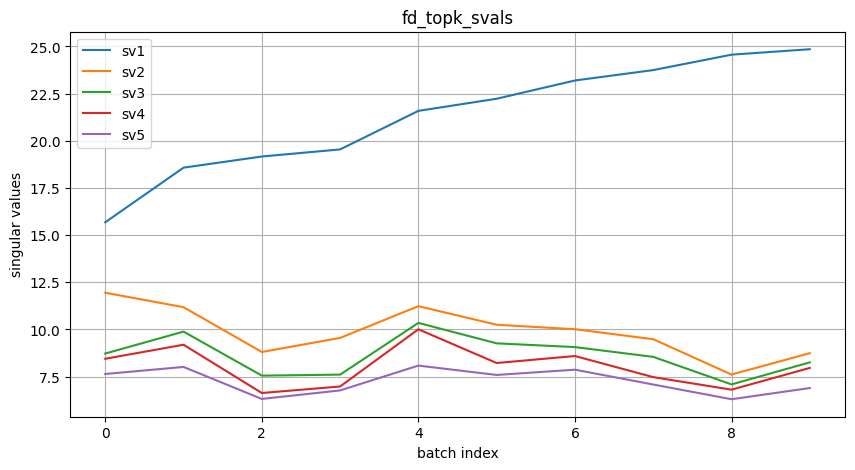

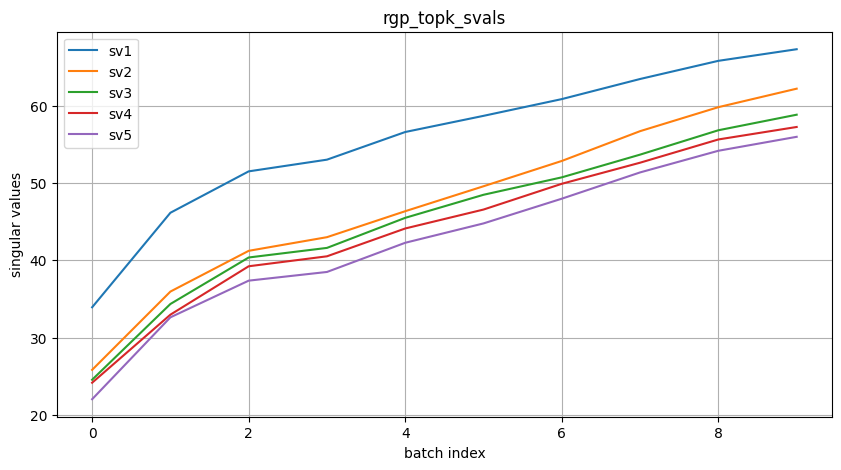

In [26]:
plot_topk_over_time(records, which='fd_topk_svals', topk_plot=5)
plot_topk_over_time(records, which='rgp_topk_svals', topk_plot=5)

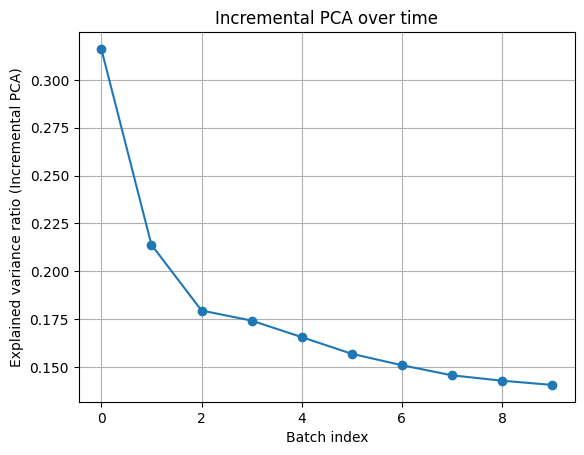

In [27]:
plt.plot(records['batch_idx'], records['ipca_explained_variance'], marker='o')
plt.xlabel('Batch index')
plt.ylabel('Explained variance ratio (Incremental PCA)')
plt.title('Incremental PCA over time')
plt.grid(True)
plt.show()

In [28]:
pd.DataFrame(records).to_csv("stream_monitor_records_fixed.csv", index=False)

## part 5

In [ ]:
def compute_frobenius_norm(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    return norm(X, 'fro')

def compute_reconstruction_error(approx_svals, true_svals):
    if true_svals is None or approx_svals is None:
        return np.nan
    minlen = min(len(true_svals), len(approx_svals))
    diff = true_svals[:minlen] - approx_svals[:minlen]
    return norm(diff) / norm(true_svals[:minlen])

def compute_ev_ratio(ipca_ev):
    return ipca_ev if ipca_ev is not None else np.nan


df_metrics = pd.DataFrame({
    "batch": records['batch_name'],
    "fd_sv": records['fd_topk_svals'],
    "rgp_sv": records['rgp_topk_svals'],
    "true_sv": records['true_topk_svals'],
    "ipca_ev": records['ipca_explained_variance']
})

results = []

for i, row in df_metrics.iterrows():
    true_s = row['true_sv']
    fd_s = row['fd_sv']
    rgp_s = row['rgp_sv']
    ev_ipca = compute_ev_ratio(row['ipca_ev'])

    fd_err = compute_reconstruction_error(fd_s, true_s)
    rgp_err = compute_reconstruction_error(rgp_s, true_s)

    frob_fd = np.sqrt(np.sum(np.square(fd_s))) if fd_s is not None else np.nan
    frob_rgp = np.sqrt(np.sum(np.square(rgp_s))) if rgp_s is not None else np.nan
    frob_true = np.sqrt(np.sum(np.square(true_s))) if true_s is not None else np.nan

    results.append({
        "batch": row['batch'],
        "frobenius_true": frob_true,
        "frobenius_fd": frob_fd,
        "frobenius_rgp": frob_rgp,
        "reconstruction_fd": fd_err,
        "reconstruction_rgp": rgp_err,
        "explained_variance_ipca": ev_ipca
    })

metrics_df = pd.DataFrame(results)
# metrics_df['frobenius_true'] = metrics_df['frobenius_true'].fillna(method='ffill')
# metrics_df['reconstruction_fd'] = metrics_df['reconstruction_fd'].fillna(method='ffill')
# metrics_df['reconstruction_rgp'] = metrics_df['reconstruction_rgp'].fillna(method='ffill')
metrics_df

,batch,frobenius_true,frobenius_fd,frobenius_rgp,reconstruction_fd,reconstruction_rgp,explained_variance_ipca
0,2010-11-29/2010-12-05,51.151299,33.290021,88.392205,0.360406,0.761246,0.316166
1,2010-12-06/2010-12-12,64.799963,35.652797,130.550192,0.459242,1.061447,0.213843
2,2010-12-13/2010-12-19,71.254635,30.780443,153.760569,0.583491,1.213843,0.179439
3,2010-12-20/2010-12-26,72.917306,30.937965,159.429118,0.596027,1.243969,0.174179
4,2011-01-03/2011-01-09,78.464044,36.476263,173.963495,0.552061,1.278143,0.165532
5,2011-01-10/2011-01-16,82.423365,35.913720,185.688242,0.579580,1.317955,0.156808
6,2011-01-17/2011-01-23,86.446345,36.311480,197.004755,0.596671,1.348184,0.150863
7,2011-01-24/2011-01-30,91.176757,35.277515,210.233198,0.632774,1.378266,0.145569
8,2011-01-31/2011-02-06,95.559594,33.203129,221.238881,0.680801,1.390158,0.142761
9,2011-02-07/2011-02-13,98.511507,35.301196,229.196549,0.662951,1.403569,0.140558


## Part 6

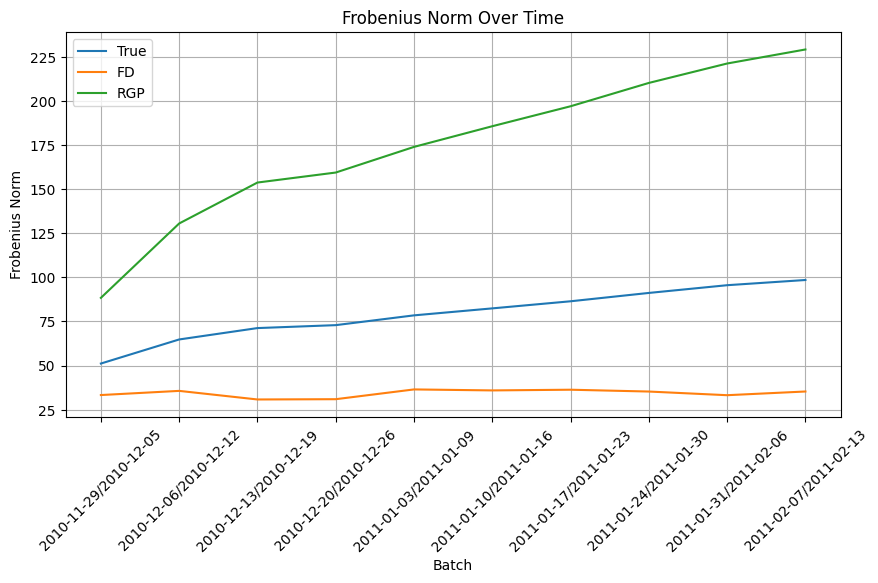

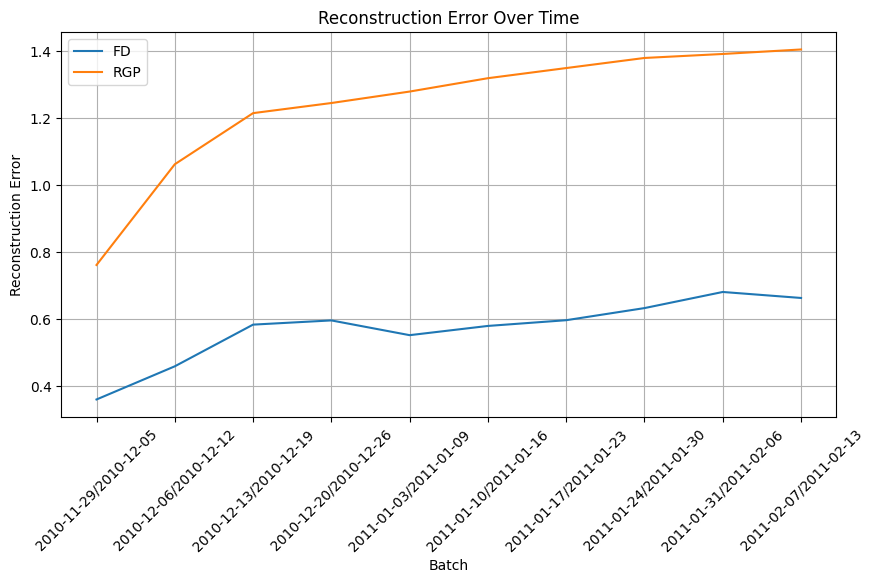

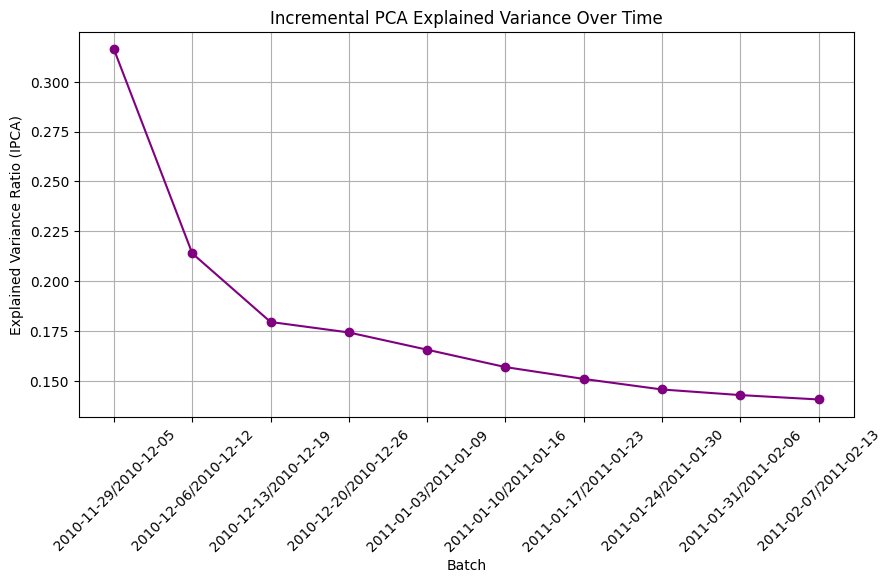

In [ ]:
def plot_metrics_over_time(metrics_df, topk_plot=5):
    batches = metrics_df['batch']

    # --------- Frobenius Norm ---------
    plt.figure(figsize=(10,5))
    plt.plot(batches, metrics_df['frobenius_true'], label='True')
    plt.plot(batches, metrics_df['frobenius_fd'], label='FD')
    plt.plot(batches, metrics_df['frobenius_rgp'], label='RGP')
    plt.xticks(rotation=45)
    plt.ylabel('Frobenius Norm')
    plt.xlabel('Batch')
    plt.title('Frobenius Norm Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --------- Reconstruction Error ---------
    plt.figure(figsize=(10,5))
    plt.plot(batches, metrics_df['reconstruction_fd'], label='FD')
    plt.plot(batches, metrics_df['reconstruction_rgp'], label='RGP')
    plt.xticks(rotation=45)
    plt.ylabel('Reconstruction Error')
    plt.xlabel('Batch')
    plt.title('Reconstruction Error Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --------- Incremental PCA Explained Variance ---------
    plt.figure(figsize=(10,5))
    plt.plot(batches, metrics_df['explained_variance_ipca'], marker='o', color='purple')
    plt.xticks(rotation=45)
    plt.ylabel('Explained Variance Ratio (IPCA)')
    plt.xlabel('Batch')
    plt.title('Incremental PCA Explained Variance Over Time')
    plt.grid(True)
    plt.show()

plot_metrics_over_time(metrics_df)

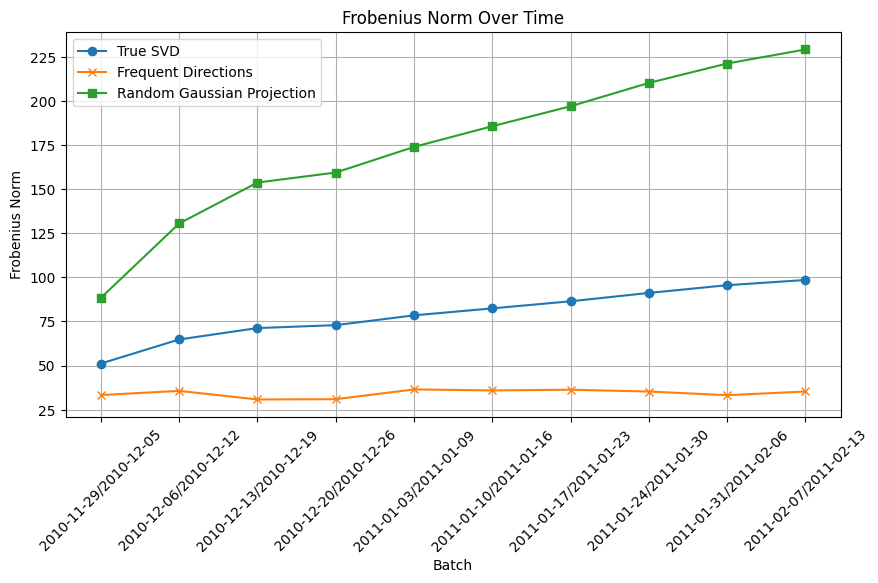

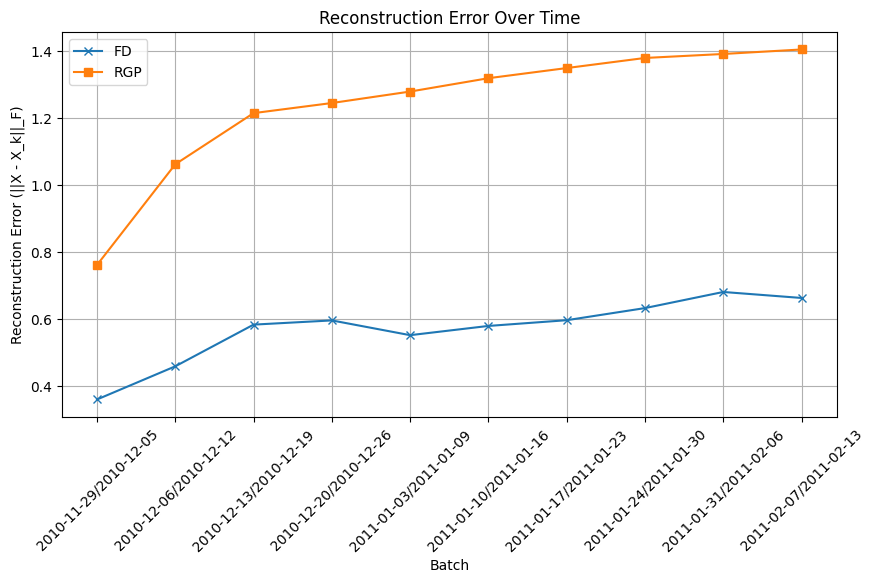

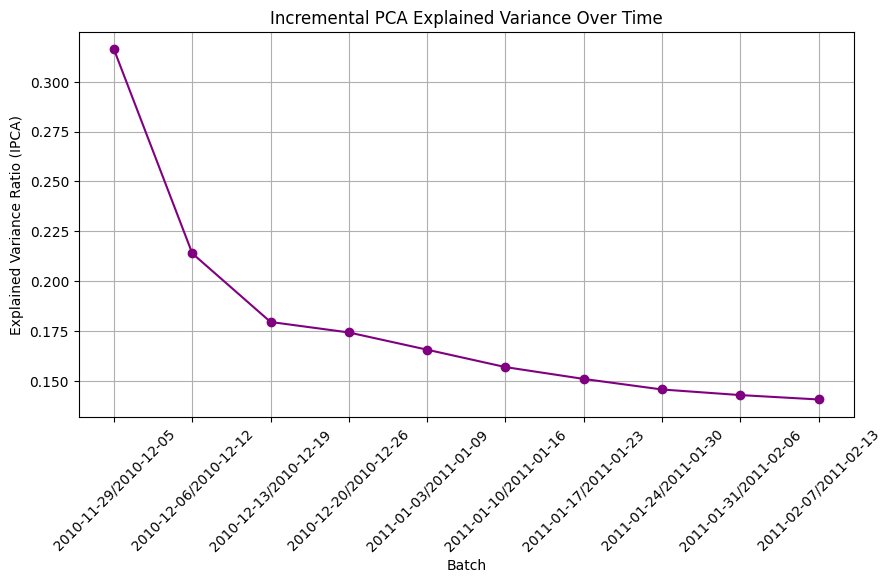

In [ ]:

def plot_all_metrics(metrics_df, topk_plot=5):
    batches = metrics_df['batch']

    # ---------- Frobenius Norm ----------
    plt.figure(figsize=(10,5))
    plt.plot(batches, metrics_df['frobenius_true'], marker='o', label='True SVD')
    plt.plot(batches, metrics_df['frobenius_fd'], marker='x', label='Frequent Directions')
    plt.plot(batches, metrics_df['frobenius_rgp'], marker='s', label='Random Gaussian Projection')
    plt.xticks(rotation=45)
    plt.ylabel('Frobenius Norm')
    plt.xlabel('Batch')
    plt.title('Frobenius Norm Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- Reconstruction Error ----------
    plt.figure(figsize=(10,5))
    plt.plot(batches, metrics_df['reconstruction_fd'], marker='x', label='FD')
    plt.plot(batches, metrics_df['reconstruction_rgp'], marker='s', label='RGP')
    plt.xticks(rotation=45)
    plt.ylabel('Reconstruction Error (||X - X_k||_F)')
    plt.xlabel('Batch')
    plt.title('Reconstruction Error Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- Incremental PCA Explained Variance ----------
    plt.figure(figsize=(10,5))
    plt.plot(batches, metrics_df['explained_variance_ipca'], marker='o', color='purple')
    plt.xticks(rotation=45)
    plt.ylabel('Explained Variance Ratio (IPCA)')
    plt.xlabel('Batch')
    plt.title('Incremental PCA Explained Variance Over Time')
    plt.grid(True)
    plt.show()

    # ---------- Top-k singular values from sketches ----------
    if 'fd_topk_svals' in metrics_df.columns:
        plt.figure(figsize=(10,5))
        for i in range(topk_plot):
            vals = [arr[i] if arr is not None and len(arr) > i else np.nan for arr in metrics_df['fd_topk_svals']]
            plt.plot(batches, vals, label=f'FD sv{i+1}')
        plt.xticks(rotation=45)
        plt.ylabel('Singular Values (FD)')
        plt.xlabel('Batch')
        plt.title(f'Top-{topk_plot} Singular Values Over Time (FD)')
        plt.legend()
        plt.grid(True)
        plt.show()

    if 'rgp_topk_svals' in metrics_df.columns:
        plt.figure(figsize=(10,5))
        for i in range(topk_plot):
            vals = [arr[i] if arr is not None and len(arr) > i else np.nan for arr in metrics_df['rgp_topk_svals']]
            plt.plot(batches, vals, label=f'RGP sv{i+1}')
        plt.xticks(rotation=45)
        plt.ylabel('Singular Values (RGP)')
        plt.xlabel('Batch')
        plt.title(f'Top-{topk_plot} Singular Values Over Time (RGP)')
        plt.legend()
        plt.grid(True)
        plt.show()

plot_all_metrics(metrics_df, topk_plot=5)

## Part 7

In [32]:
# !pip install mlxtend

In [ ]:
import pandas as pd
from itertools import combinations
from collections import defaultdict
from scipy import sparse
import time
import warnings
warnings.filterwarnings("ignore")

def csr_to_transactions(X_csr, items):
    transactions = []
    X_coo = X_csr.tocoo()
    n_rows = X_csr.shape[0]
    row_dict = {i: [] for i in range(n_rows)}
    for r, c in zip(X_coo.row, X_coo.col):
        row_dict[r].append(items[c])
    for r in range(n_rows):
        transactions.append(row_dict[r])
    return transactions

def apriori_from_transactions(transactions, min_support=0.05):
    n_transactions = len(transactions)
    support_count = defaultdict(int)

    for txn in transactions:
        for item in txn:
            support_count[frozenset([item])] += 1

    frequent_itemsets = {k for k, v in support_count.items() if v / n_transactions >= min_support}
    all_frequent_itemsets = set(frequent_itemsets)

    k = 2
    while frequent_itemsets:
        candidate_itemsets = set()
        frequent_list = list(frequent_itemsets)
        for i in range(len(frequent_list)):
            for j in range(i+1, len(frequent_list)):
                union_set = frequent_list[i] | frequent_list[j]
                if len(union_set) == k:
                    candidate_itemsets.add(union_set)

        support_count = defaultdict(int)
        for txn in transactions:
            txn_set = set(txn)
            for candidate in candidate_itemsets:
                if candidate.issubset(txn_set):
                    support_count[candidate] += 1

        frequent_itemsets = {k for k, v in support_count.items() if v / n_transactions >= min_support}
        all_frequent_itemsets |= frequent_itemsets
        k += 1

    itemsets_list = []
    support_list = []
    for itemset in all_frequent_itemsets:
        count = sum(1 for txn in transactions if itemset.issubset(set(txn)))
        itemsets_list.append(tuple(itemset))
        support_list.append(count / n_transactions)

    return pd.DataFrame({'itemsets': itemsets_list, 'support': support_list})

def compare_patterns(patterns_orig, patterns_fd):
    orig_sets = set(frozenset(x) for x in patterns_orig['itemsets'])
    fd_sets = set(frozenset(x) for x in patterns_fd['itemsets'])
    
    common = orig_sets & fd_sets
    similarity = len(common) / max(len(orig_sets), 1)
    
    print(f"Original patterns: {len(orig_sets)}")
    print(f"FD sketch patterns: {len(fd_sets)}")
    print(f"Common patterns: {len(common)}")
    print(f"Similarity ratio: {similarity:.2f}")
    
    return similarity

def mine_patterns_on_batches(batches_ordered, min_support=0.05, fd_ell=50):
    results = []

    for idx, (bname, bdf) in enumerate(batches_ordered):
        print(f"\nBatch {idx+1}/{len(batches_ordered)}: {bname}")

        X_batch, invoices, items = build_item_transaction_matrix(bdf)
        transactions = csr_to_transactions(X_batch, items)

        start = time.time()
        patterns_true = apriori_from_transactions(transactions, min_support=min_support)
        time_true = time.time() - start

        d = X_batch.shape[1]
        fd = FrequentDirections(ell=fd_ell, d=d)
        fd.process_block(X_batch)
        B = fd.get_sketch()
        fd_binary = (B > 0).astype(int)
        transactions_fd = csr_to_transactions(sparse.csr_matrix(fd_binary), items)

        start = time.time()
        patterns_fd = apriori_from_transactions(transactions_fd, min_support=min_support)
        time_fd = time.time() - start

        similarity = compare_patterns(patterns_true, patterns_fd)

        results.append({
            'batch': bname,
            'n_patterns_original': len(patterns_true),
            'time_original': time_true,
            'n_patterns_fd': len(patterns_fd),
            'time_fd': time_fd,
            'similarity_fd': similarity
        })

        print(f"Time Original: {time_true:.4f}s | Time FD: {time_fd:.4f}s | Similarity: {similarity:.2f}")

    return pd.DataFrame(results)

# patterns_comparison_df = mine_patterns_on_batches(batches_ordered[:10], min_support=0.05, fd_ell=50)
# patterns_comparison_df



In [ ]:
import numpy as np
from scipy import sparse
import pandas as pd

def quick_pattern_similarity(X_csr, X_sketch_csr):
    
    n = X_csr.shape[0]
    
    freq_orig = (X_csr.sum(axis=0) / n).A1  # normalized frequency
    freq_sketch = (X_sketch_csr.sum(axis=0) / n).A1
    
    sim_score = 1 - np.mean(np.abs(freq_orig - freq_sketch))
    return sim_score

def analyze_pattern_preservation(batches_ordered, fd_ell=50):
    results = []
    
    for idx, (bname, bdf) in enumerate(batches_ordered):
        print(f"Processing batch {idx+1}/{len(batches_ordered)}: {bname}")
        
        X_batch, invoices, items = build_item_transaction_matrix(bdf)
        
        fd = FrequentDirections(ell=fd_ell, d=X_batch.shape[1])
        fd.process_block(X_batch)
        B = fd.get_sketch()
        B_binary = (B > 0).astype(int)  
        
        sim_score = quick_pattern_similarity(X_batch, sparse.csr_matrix(B_binary))
        
        results.append({
            "batch": bname,
            "similarity_1item": sim_score
        })
    
    return pd.DataFrame(results)

pattern_preservation_df = analyze_pattern_preservation(batches_ordered[:10], fd_ell=50)
pattern_preservation_df


Processing batch 1/10: 2010-11-29/2010-12-05
Processing batch 2/10: 2010-12-06/2010-12-12
Processing batch 3/10: 2010-12-13/2010-12-19
Processing batch 4/10: 2010-12-20/2010-12-26
Processing batch 5/10: 2011-01-03/2011-01-09
Processing batch 6/10: 2011-01-10/2011-01-16
Processing batch 7/10: 2011-01-17/2011-01-23
Processing batch 8/10: 2011-01-24/2011-01-30
Processing batch 9/10: 2011-01-31/2011-02-06
Processing batch 10/10: 2011-02-07/2011-02-13


,batch,similarity_1item
0,2010-11-29/2010-12-05,0.956578
1,2010-12-06/2010-12-12,0.968059
2,2010-12-13/2010-12-19,0.958292
3,2010-12-20/2010-12-26,0.849082
4,2011-01-03/2011-01-09,0.927185
5,2011-01-10/2011-01-16,0.923115
6,2011-01-17/2011-01-23,0.916433
7,2011-01-24/2011-01-30,0.943633
8,2011-01-31/2011-02-06,0.935555
9,2011-02-07/2011-02-13,0.904997


## Part 8

Batch 1: 2010-11-29/2010-12-05, anomaly=False, nnz=7387, EV_ipca=0.2048
Batch 2: 2010-12-06/2010-12-12, anomaly=False, nnz=16615, EV_ipca=0.1341
Batch 3: 2010-12-13/2010-12-19, anomaly=False, nnz=23530, EV_ipca=0.1115
Batch 4: 2010-12-20/2010-12-26, anomaly=True, nnz=26450, EV_ipca=0.1255
Batch 5: 2011-01-03/2011-01-09, anomaly=False, nnz=31602, EV_ipca=0.1153
Batch 6: 2011-01-10/2011-01-16, anomaly=False, nnz=36188, EV_ipca=0.1071
Batch 7: 2011-01-17/2011-01-23, anomaly=False, nnz=40761, EV_ipca=0.1015
Batch 8: 2011-01-24/2011-01-30, anomaly=False, nnz=46225, EV_ipca=0.0960


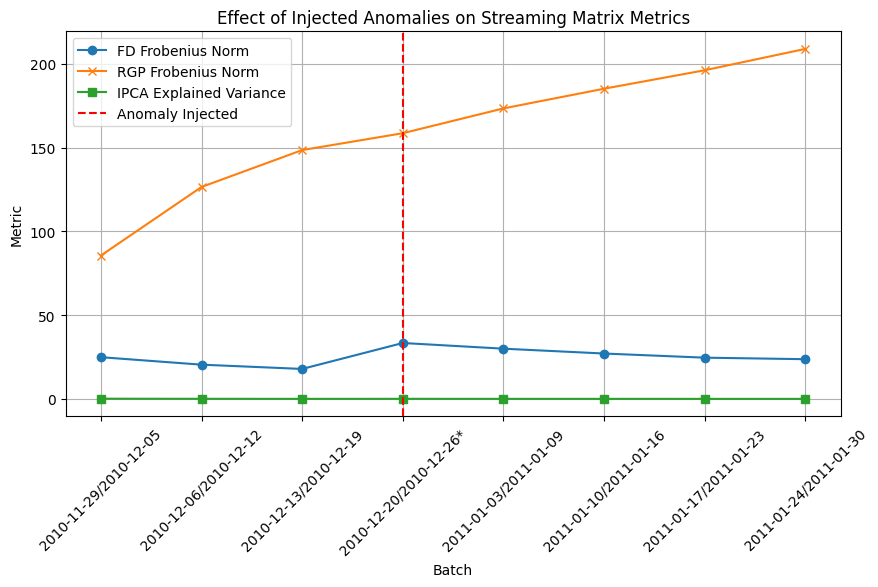

In [ ]:
def inject_anomalies(X_csr, items, n_anomalies=5, anomaly_type='rare_items'):
    
    n_items = X_csr.shape[1]
    anomalies = []

    for _ in range(n_anomalies):
        row = np.zeros(n_items, dtype=int)
        if anomaly_type == 'rare_items':
            rare_idx = np.random.choice(n_items, size=max(1, n_items//10), replace=False)
            row[rare_idx] = 1
        elif anomaly_type == 'dense':
            row[:] = 1
        anomalies.append(row)

    X_anomaly = sparse.csr_matrix(np.vstack(anomalies))
    X_augmented = sparse.vstack([X_csr, X_anomaly], format='csr')
    return X_augmented, X_anomaly

def monitor_with_anomalies(batches_ordered, item_to_idx, n_items, k=20, n_anomalies=5):
    d = n_items
    ran = RandomGaussianSketch(d=d, k=k, seed=0)
    ipca = IncrementalPCA(n_components=k)
    fd = FrequentDirections(ell=max(2*k, k+5), d=d)

    cumulative_rows = []
    records = {
        'batch_idx': [], 'batch_name': [], 'n_transactions': [],
        'nonzeros_cumulative': [], 'fd_topk_svals': [], 'rgp_topk_svals': [],
        'ipca_explained_variance': [], 'anomaly_added': []
    }

    t0 = time.time()
    for idx, (bname, bdf) in enumerate(batches_ordered):
        X_batch_global, _ = build_batch_matrix_with_global_vocab(bdf, item_to_idx, n_items)

        anomaly_flag = False
        if idx == 3:  
            X_batch_global, X_anomaly = inject_anomalies(X_batch_global, list(item_to_idx.keys()), n_anomalies)
            anomaly_flag = True

        cumulative_rows.append(X_batch_global)
        X_cumulative = sparse.vstack(cumulative_rows, format='csr')

        ran.update(X_batch_global)
        ipca.partial_fit(X_batch_global.toarray().astype(float))
        fd.process_block(X_batch_global)

        B = fd.get_sketch()
        fd_svals = topk_singular_values_dense_or_sparse(B, k=min(k, B.shape[0]-1))
        S_rg = ran.get_sketch_matrix()
        rgp_svals = topk_singular_values_dense_or_sparse(S_rg, k=min(k, min(S_rg.shape)-1))
        try:
            ev_ratio = float(ipca.explained_variance_ratio_.sum())
        except:
            ev_ratio = np.nan

        records['batch_idx'].append(idx)
        records['batch_name'].append(bname)
        records['n_transactions'].append(X_cumulative.shape[0])
        records['nonzeros_cumulative'].append(X_cumulative.nnz)
        records['fd_topk_svals'].append(fd_svals)
        records['rgp_topk_svals'].append(rgp_svals)
        records['ipca_explained_variance'].append(ev_ratio)
        records['anomaly_added'].append(anomaly_flag)

        print(f"Batch {idx+1}: {bname}, anomaly={anomaly_flag}, nnz={X_cumulative.nnz}, EV_ipca={ev_ratio:.4f}")

    return records

records_anomaly = monitor_with_anomalies(batches_ordered[:8], item_to_idx, n_items, k=10, n_anomalies=3)

def plot_anomaly_effect(records):
    batches = [f"{name}{'*' if anomaly else ''}" 
               for name, anomaly in zip(records['batch_name'], records['anomaly_added'])]
    
    fd_norm = [np.sqrt(np.sum(np.square(svals))) for svals in records['fd_topk_svals']]
    rgp_norm = [np.sqrt(np.sum(np.square(svals))) for svals in records['rgp_topk_svals']]
    ipca_ev = records['ipca_explained_variance']

    plt.figure(figsize=(10,5))
    plt.plot(fd_norm, marker='o', label='FD Frobenius Norm')
    plt.plot(rgp_norm, marker='x', label='RGP Frobenius Norm')
    plt.plot(ipca_ev, marker='s', label='IPCA Explained Variance')
    if any(records['anomaly_added']):
        anomaly_idx = records['anomaly_added'].index(True)
        plt.axvline(anomaly_idx, color='red', linestyle='--', label='Anomaly Injected')
    
    plt.xticks(range(len(batches)), batches, rotation=45)
    plt.ylabel('Metric')
    plt.xlabel('Batch')
    plt.title('Effect of Injected Anomalies on Streaming Matrix Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_anomaly_effect(records_anomaly)